In [58]:
from __future__ import unicode_literals, print_function, division, absolute_import
!pip install tensorflow==2.0.0-beta1

In [59]:
#import
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#checking tensorflow and keras version
print(tf.__version__)
tf.print(tf.__version__)
print(tf.keras.__version__)

2.0.0-beta1
2.0.0-beta1
2.2.4-tf


###Load and Prepare MNIST Hand-written digit data

In [60]:
# Load and Prepare MNIST data.
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


#checking datatypes
print(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype)

uint8 uint8 uint8 uint8


In [61]:
#coverting to float32 as random generated weight will be in float32
x_train, x_test = tf.cast(x_train, np.float32), tf.cast(x_test, np.float32)
x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype

(tf.float32, dtype('uint8'), tf.float32, dtype('uint8'))

In [62]:
# Normalize images value as max value is 255
x_train, x_test = x_train / 255, x_test / 255

#checking shape for all and unique labels in target
x_train.shape, y_train.shape, x_test.shape, y_test.shape, np.unique(y_train)

(TensorShape([60000, 28, 28]),
 (60000,),
 TensorShape([10000, 28, 28]),
 (10000,),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

Traing Set Sample Display:
 image no:20126   Label:9


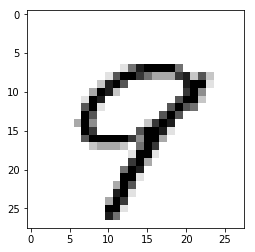

Test Set Sample Display:
 image no:174   Label:2


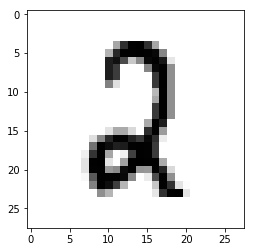

In [63]:
#display image from train set and test set
def display_image_label(featureset, labelset):
  img_no= np.random.randint(0, featureset.shape[0])
  img = featureset[img_no]
  label= labelset[img_no]
  print(f" image no:{img_no}   Label:{label}") # multiplying with 255 as we scaled with it
  plt.imshow(img, cmap=plt.cm.binary)
  plt.show()
  
print("Traing Set Sample Display:\n","="*50)
display_image_label(x_train, y_train)

print("Test Set Sample Display:\n","="*50)
display_image_label(x_test, y_test)

In [0]:
#parameter Declaration
# MNIST dataset parameters.
num_classes = 10 # (0-9 digits).


# Training parameters.
learning_rate = 0.01
training_steps = 500
batch_size = 156
display_step = 50

In [65]:
#Creating Batches

train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(200).batch(batch_size).prefetch(1)
train

<PrefetchDataset shapes: ((None, 28, 28), (None,)), types: (tf.float32, tf.uint8)>

In [0]:
#creating functions for convolution and pooling, for modular approach to perform hidden layer (convolution) functionality
# convolution function to perform single full pass of convolution till activation except pooling for a single hidden layer
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

#Pooling function to perform max_pooling after each conv2d()   
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [0]:
#convolution filter and fully connected hidden layers parameter

#conv filter (window size)
conv_filter_width=5
conv_filter_height=5
#conv layer 1
conv1_input=1
conv1_filtered_output=16

#conv layer 2
conv2_filtered_output=64

#fully connected layer1
fc1_units=1024


#initialize random normal weights and biases

#using random_normal_initializer() of tf r2.0.0 beta1
normal = tf.random_normal_initializer()

Weight_dict = {
    # initializing the weights with above given shapes
    'wc1': tf.Variable(normal([conv_filter_height,conv_filter_width,conv1_input,conv1_filtered_output])), # for first hidden convolution layer, weights
    'wc2': tf.Variable(normal([conv_filter_height,conv_filter_width,conv1_filtered_output,conv2_filtered_output])), # for second hidden convolution layer, weights
    'wfc1': tf.Variable(normal([7*7*conv2_filtered_output, fc1_units])), ## for first fully connected hidden layer, weights
    'w_out': tf.Variable(normal([fc1_units, num_classes])) # # for output layer, weights
}
bias_dict = {
    # intializing the biases with above given shape configuration
    'b1': tf.Variable(tf.zeros([conv1_filtered_output])), ## for first hidden convolution layer, bias vector
    'b2': tf.Variable(tf.zeros([conv2_filtered_output])), # for second hidden convolution layer, bias vector
    'bfc1': tf.Variable(tf.zeros([fc1_units])),    # for first fully connected hidden layer, bias vectors
    'b_out': tf.Variable(tf.zeros([num_classes])) # bias vector for output layer
}

In [0]:
# model creation
def model_convNET(x):
    
    # Reshaping the input to [-1, 28, 28, 1] to make a batch of 28x28x1 (grayscale) images.
    x = tf.reshape(x, [-1, 28, 28, 1])
    #print(x.shape)
    # performing convolution. Layer  Output shape would be [-1, 28, 28, 16]
    convLayer1 = conv2d(x, Weight_dict['wc1'], bias_dict['b1'])
    #print(convLayer1.shape)
    # Performing Max Pooling (down-sampling). Output shape would be [-1, 14, 14, 16].
    convLayer1 = maxpool2d(convLayer1, k=2)
   # print(convLayer1.shape)
    # performing convolution again. Layer Output shape would be [-1, 14, 14, 64].
    convLayer2 = conv2d(convLayer1, Weight_dict['wc2'], bias_dict['b2'])
    #print(convLayer2.shape)
    # Performing Max Pooling (down-sampling). Output shape would be [-1, 7, 7, 64]
    convLayer2 = maxpool2d(convLayer2, k=2)
    #print(convLayer2.shape)
    # Reshape convLayer2 output to fit fully connected layer input, Output shape: [-1, 7*7*64].
   # print(tf.reshape(convLayer2, [-1, Weight_dict['wfc1'].get_shape().as_list()[0]]).shape)
    fcLayer1 = tf.reshape(convLayer2, [-1, Weight_dict['wfc1'].get_shape().as_list()[0]])
    
    # Fully connected layer, Output shape: [-1, 512].
    fcLayer1 = tf.add(tf.matmul(fcLayer1, Weight_dict['wfc1']), bias_dict['bfc1'])
    # Apply ReLU to fcLayer1 output for non-linearity.
    fcLayer1 = tf.nn.relu(fcLayer1)

    # Fully connected layer1, Output shape: [-1, 10].
    outLayer = tf.add(tf.matmul(fcLayer1, Weight_dict['w_out']), bias_dict['b_out'])
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(outLayer)

In [0]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# ADAM optimizer.
optimizer = tf.optimizers.Adam(learning_rate)

In [0]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = model_convNET(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = [Weight_dict['wc1'], Weight_dict['wc2'],Weight_dict['wfc1'],Weight_dict['w_out'], bias_dict['b1'], bias_dict['b2'], bias_dict['bfc1'], bias_dict['b_out'] ]

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [80]:
#on training set
#collect loss and accuracy
loss_list, accuracy_list = [], []
for step, (batch_x, batch_y) in enumerate(train.take(training_steps), 1):
    # Execute optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = model_convNET(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_list.append(loss)
        acc = accuracy(pred, batch_y)
        accuracy_list.append(acc)
        print(f"step: {step}, loss: {loss}, accuracy: {acc}")

step: 50, loss: 2.402210235595703, accuracy: 0.9935897588729858
step: 100, loss: 0.2989310324192047, accuracy: 1.0
step: 150, loss: 1.6169856786727905, accuracy: 0.9935897588729858
step: 200, loss: 4.34576416015625, accuracy: 0.9871794581413269
step: 250, loss: 8.964117050170898, accuracy: 0.9871794581413269
step: 300, loss: 1.8367652893066406, accuracy: 1.0
step: 350, loss: 1.8396852016448975, accuracy: 0.9935897588729858
step: 400, loss: 0.46888241171836853, accuracy: 1.0
step: 450, loss: 1.4739959239959717, accuracy: 1.0
step: 500, loss: 1.0728510618209839, accuracy: 1.0


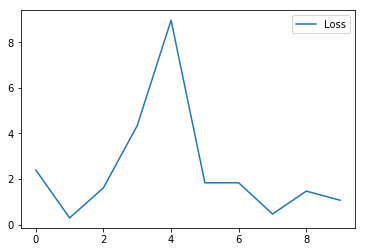

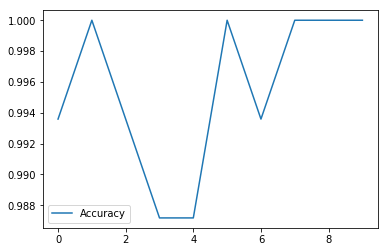

In [81]:
# plot loss and accuracy

def loss_plot(l1):
  plt.plot(l1, label="Loss")
  plt.legend()
  plt.show()

def acc_plot(l2):
  plt.plot(l2, label="Accuracy")
  plt.legend()
  plt.show()
  
#call plot  
loss_plot(loss_list)
acc_plot(accuracy_list)

In [84]:
# Test model on validation set.
pred = model_convNET(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))


Test Accuracy: 0.981500


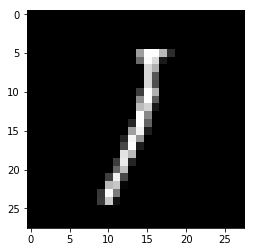

Image No. : 2885 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


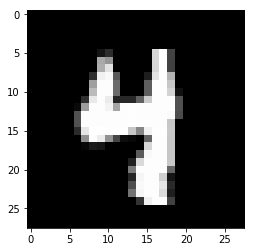

Image No. : 2886 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


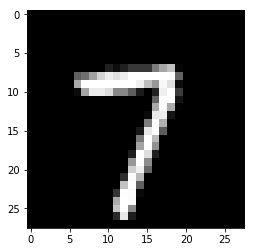

Image No. : 2887 , Predicted Label by Model :7, Actual Label: 7, Status: Congratulations! Predicted Correctly.


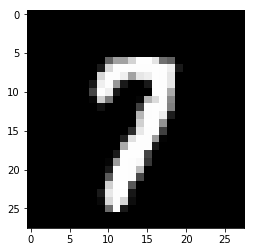

Image No. : 2888 , Predicted Label by Model :7, Actual Label: 7, Status: Congratulations! Predicted Correctly.


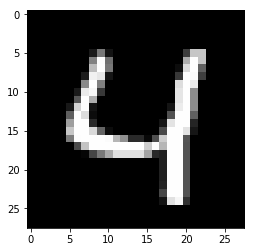

Image No. : 2889 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


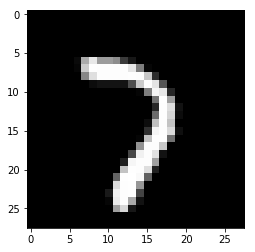

Image No. : 2890 , Predicted Label by Model :7, Actual Label: 7, Status: Congratulations! Predicted Correctly.


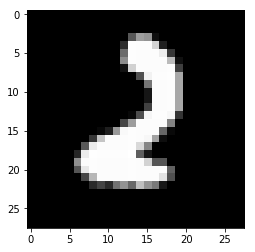

Image No. : 2891 , Predicted Label by Model :2, Actual Label: 2, Status: Congratulations! Predicted Correctly.


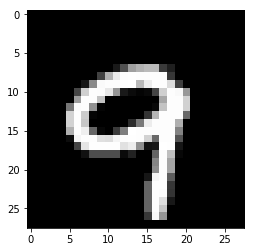

Image No. : 2892 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


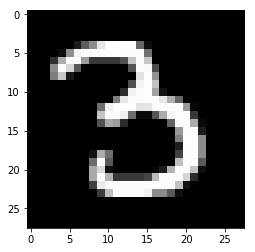

Image No. : 2893 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


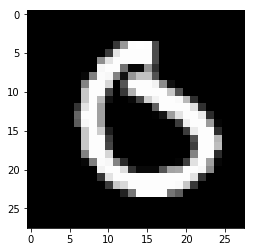

Image No. : 2894 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


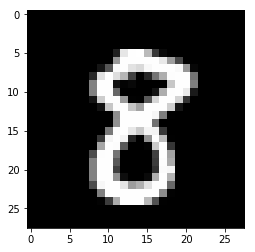

Image No. : 2895 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


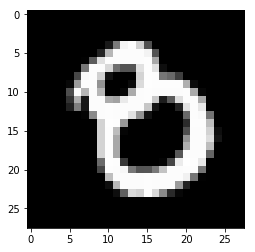

Image No. : 2896 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


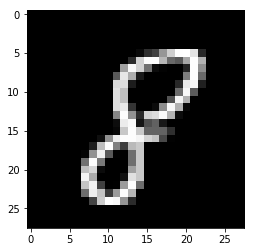

Image No. : 2897 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


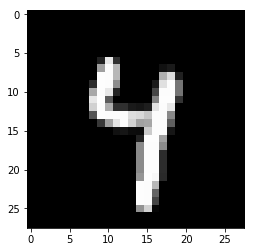

Image No. : 2898 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


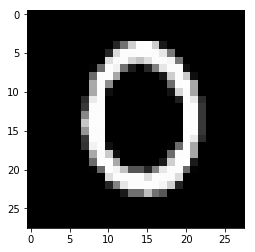

Image No. : 2899 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


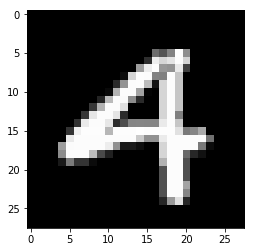

Image No. : 2900 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


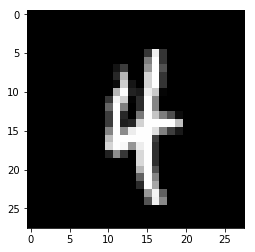

Image No. : 2901 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


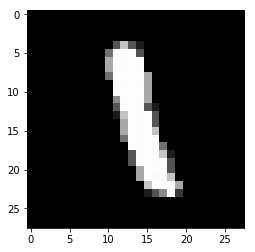

Image No. : 2902 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


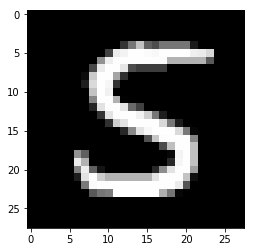

Image No. : 2903 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


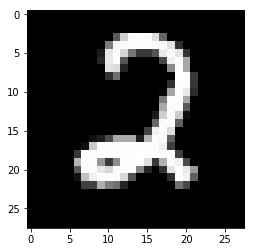

Image No. : 2904 , Predicted Label by Model :2, Actual Label: 2, Status: Congratulations! Predicted Correctly.


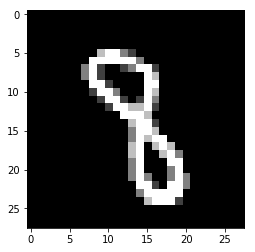

Image No. : 2905 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


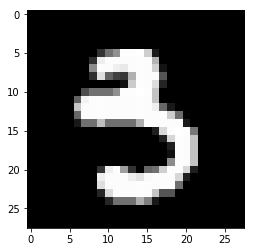

Image No. : 2906 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


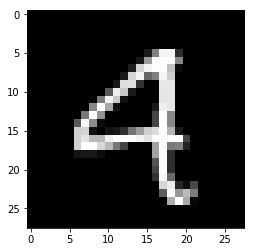

Image No. : 2907 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


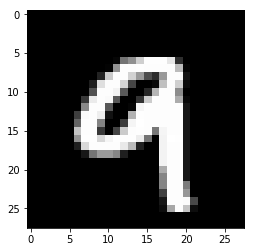

Image No. : 2908 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


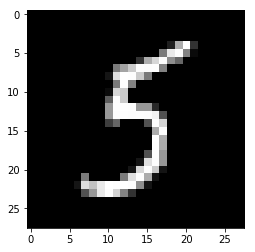

Image No. : 2909 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


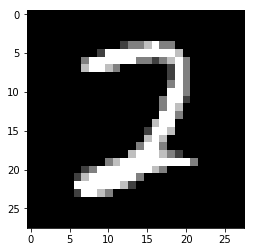

Image No. : 2910 , Predicted Label by Model :2, Actual Label: 2, Status: Congratulations! Predicted Correctly.


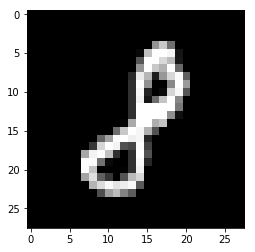

Image No. : 2911 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


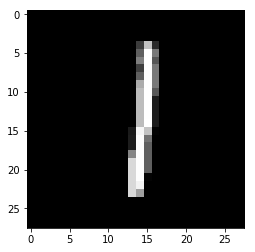

Image No. : 2912 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


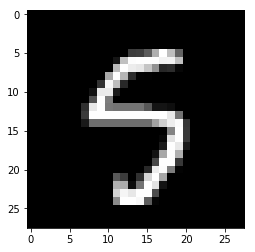

Image No. : 2913 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


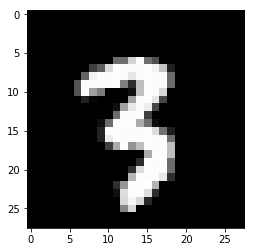

Image No. : 2914 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


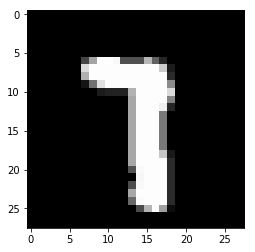

Image No. : 2915 , Predicted Label by Model :7, Actual Label: 7, Status: Congratulations! Predicted Correctly.


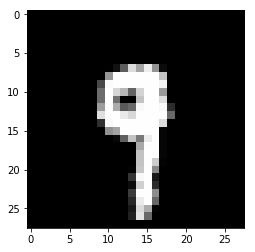

Image No. : 2916 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


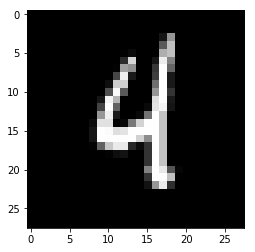

Image No. : 2917 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


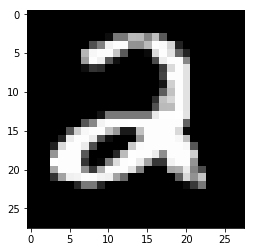

Image No. : 2918 , Predicted Label by Model :2, Actual Label: 2, Status: Congratulations! Predicted Correctly.


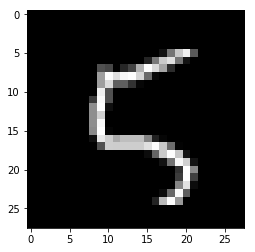

Image No. : 2919 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


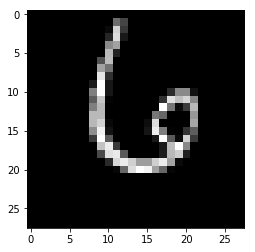

Image No. : 2920 , Predicted Label by Model :6, Actual Label: 6, Status: Congratulations! Predicted Correctly.


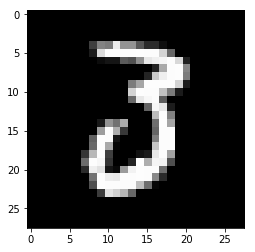

Image No. : 2921 , Predicted Label by Model :8, Actual Label: 3, Status: Opps! Wrong Prediction.


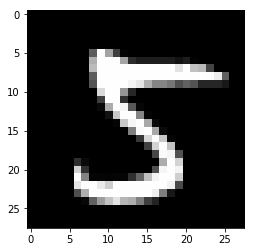

Image No. : 2922 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


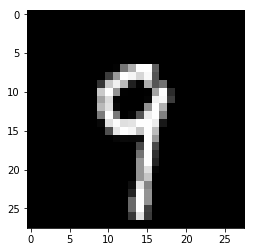

Image No. : 2923 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


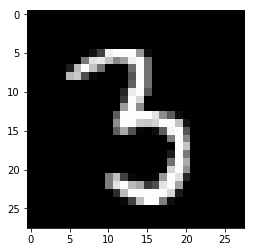

Image No. : 2924 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


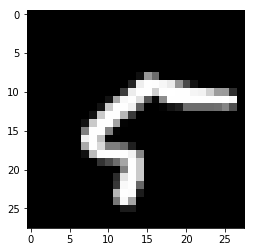

Image No. : 2925 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


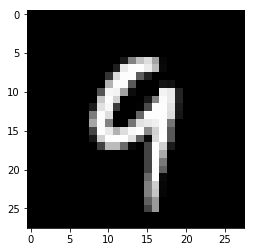

Image No. : 2926 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


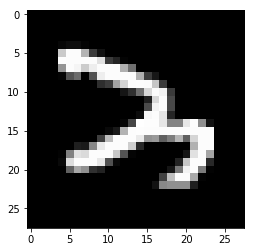

Image No. : 2927 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


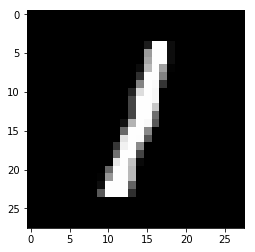

Image No. : 2928 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


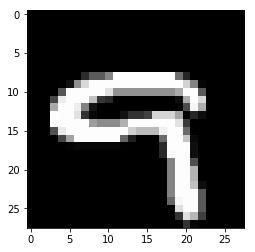

Image No. : 2929 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


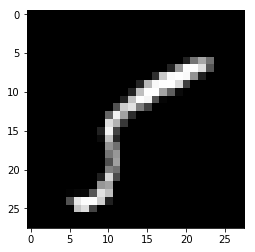

Image No. : 2930 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


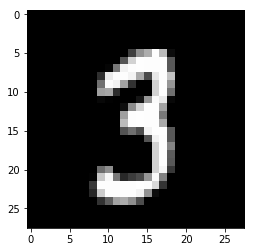

Image No. : 2931 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


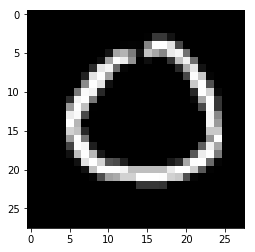

Image No. : 2932 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


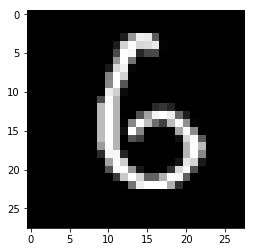

Image No. : 2933 , Predicted Label by Model :6, Actual Label: 6, Status: Congratulations! Predicted Correctly.


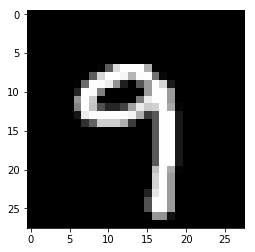

Image No. : 2934 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


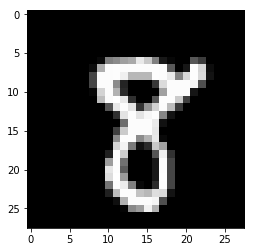

Image No. : 2935 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


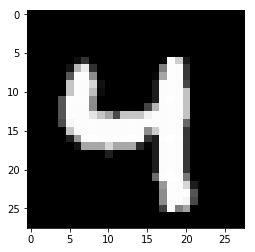

Image No. : 2936 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


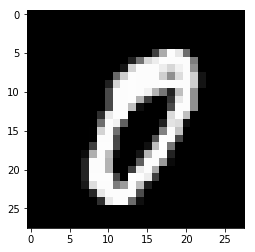

Image No. : 2937 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


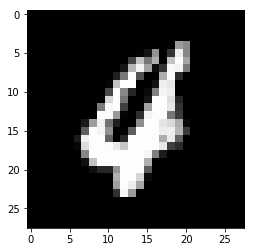

Image No. : 2938 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


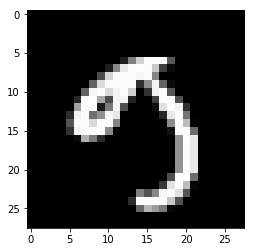

Image No. : 2939 , Predicted Label by Model :5, Actual Label: 9, Status: Opps! Wrong Prediction.


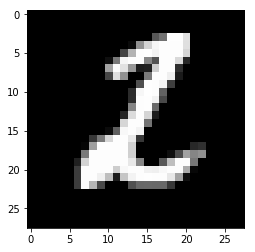

Image No. : 2940 , Predicted Label by Model :2, Actual Label: 2, Status: Congratulations! Predicted Correctly.


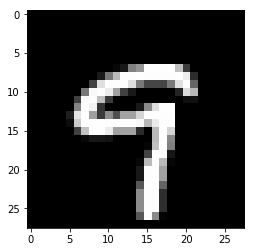

Image No. : 2941 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


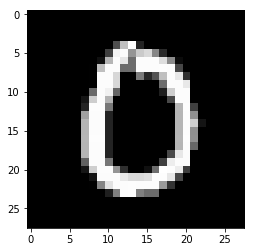

Image No. : 2942 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


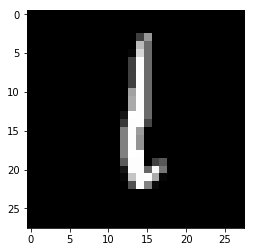

Image No. : 2943 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


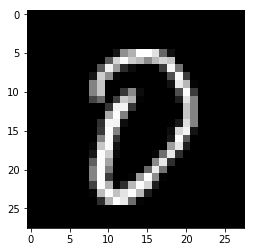

Image No. : 2944 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


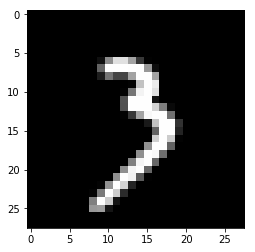

Image No. : 2945 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


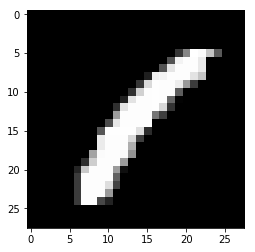

Image No. : 2946 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


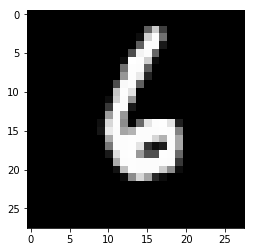

Image No. : 2947 , Predicted Label by Model :6, Actual Label: 6, Status: Congratulations! Predicted Correctly.


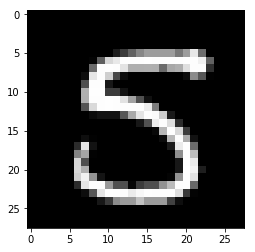

Image No. : 2948 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


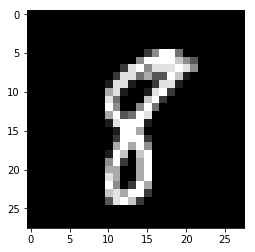

Image No. : 2949 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


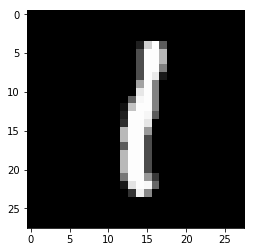

Image No. : 2950 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


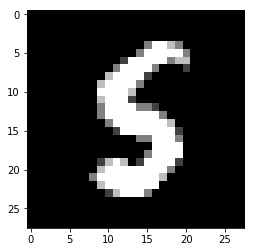

Image No. : 2953 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


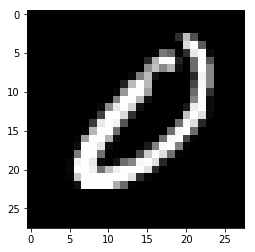

Image No. : 2954 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


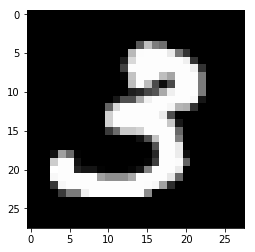

Image No. : 2955 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


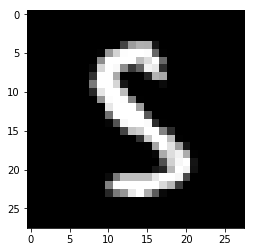

Image No. : 2956 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


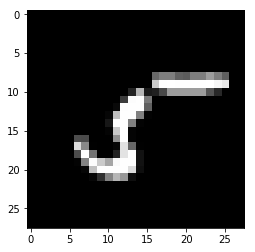

Image No. : 2957 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


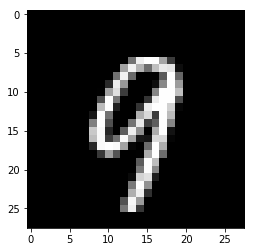

Image No. : 2958 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


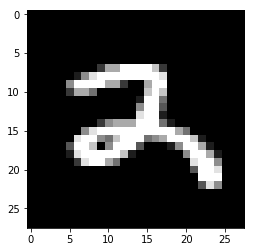

Image No. : 2959 , Predicted Label by Model :3, Actual Label: 2, Status: Opps! Wrong Prediction.


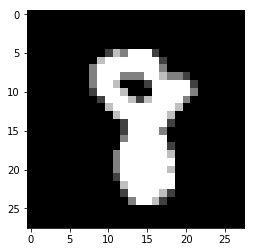

Image No. : 2960 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


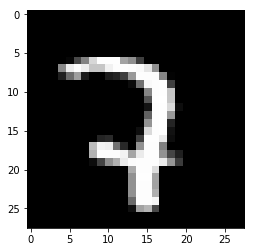

Image No. : 2961 , Predicted Label by Model :7, Actual Label: 7, Status: Congratulations! Predicted Correctly.


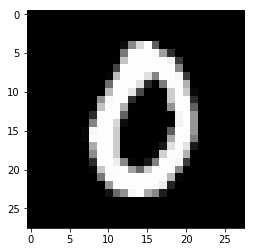

Image No. : 2962 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


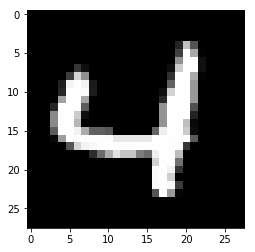

Image No. : 2963 , Predicted Label by Model :4, Actual Label: 4, Status: Congratulations! Predicted Correctly.


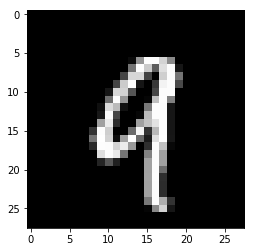

Image No. : 2964 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


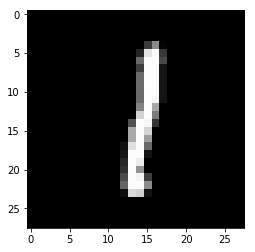

Image No. : 2965 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


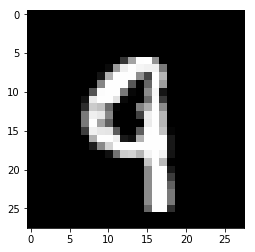

Image No. : 2966 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


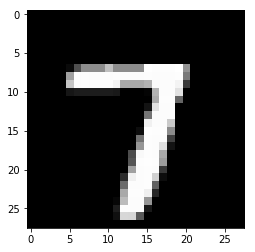

Image No. : 2967 , Predicted Label by Model :7, Actual Label: 7, Status: Congratulations! Predicted Correctly.


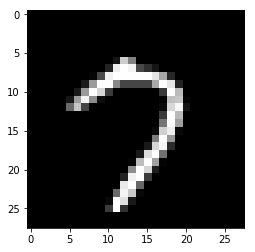

Image No. : 2968 , Predicted Label by Model :7, Actual Label: 7, Status: Congratulations! Predicted Correctly.


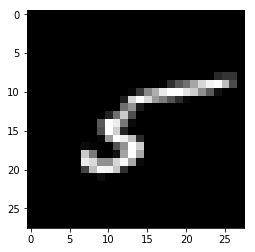

Image No. : 2969 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


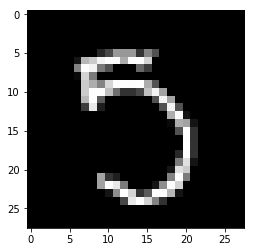

Image No. : 2970 , Predicted Label by Model :5, Actual Label: 5, Status: Congratulations! Predicted Correctly.


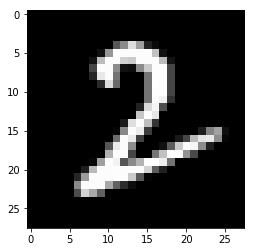

Image No. : 2971 , Predicted Label by Model :2, Actual Label: 2, Status: Congratulations! Predicted Correctly.


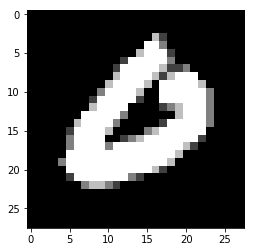

Image No. : 2972 , Predicted Label by Model :0, Actual Label: 0, Status: Congratulations! Predicted Correctly.


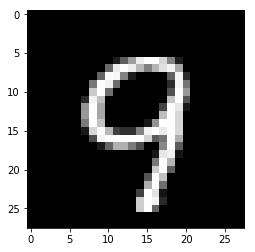

Image No. : 2973 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


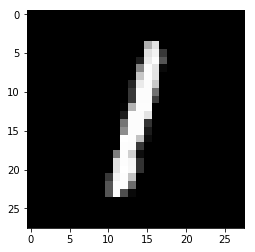

Image No. : 2974 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


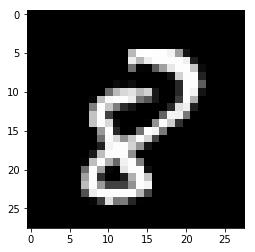

Image No. : 2975 , Predicted Label by Model :8, Actual Label: 8, Status: Congratulations! Predicted Correctly.


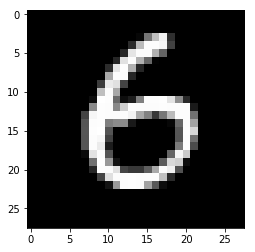

Image No. : 2976 , Predicted Label by Model :6, Actual Label: 6, Status: Congratulations! Predicted Correctly.


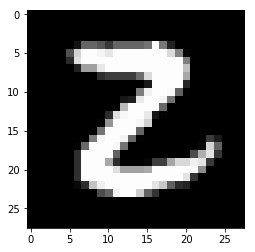

Image No. : 2977 , Predicted Label by Model :2, Actual Label: 2, Status: Congratulations! Predicted Correctly.


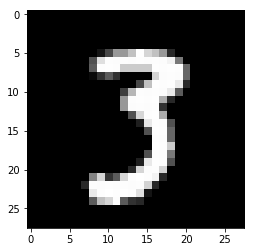

Image No. : 2978 , Predicted Label by Model :3, Actual Label: 3, Status: Congratulations! Predicted Correctly.


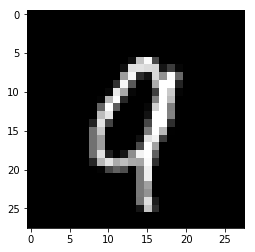

Image No. : 2979 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


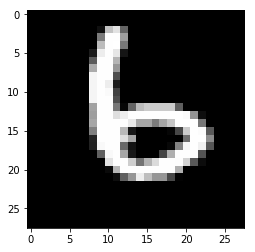

Image No. : 2980 , Predicted Label by Model :6, Actual Label: 6, Status: Congratulations! Predicted Correctly.


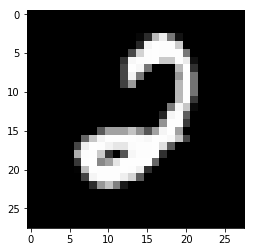

Image No. : 2981 , Predicted Label by Model :2, Actual Label: 2, Status: Congratulations! Predicted Correctly.


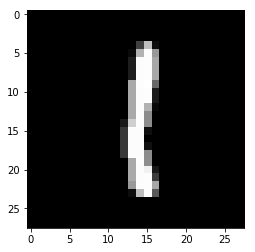

Image No. : 2982 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.


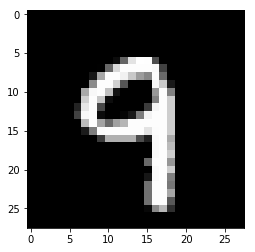

Image No. : 2983 , Predicted Label by Model :9, Actual Label: 9, Status: Congratulations! Predicted Correctly.


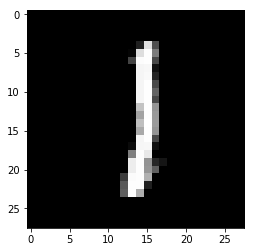

Image No. : 2984 , Predicted Label by Model :1, Actual Label: 1, Status: Congratulations! Predicted Correctly.
96 prediction out of 100


In [83]:
#random prediction and validation test on 10 images from test data selected randomly

def random_validation_test(test_dataset, test_labelset):
  start_chunk = np.random.randint(0, test_dataset.shape[0])
  end_chunk = start_chunk+100
  images = test_dataset[start_chunk:end_chunk]
  predicted = model_convNET(test_dataset[start_chunk:end_chunk]) #model used for prediction
  counter = 0;
  correct = 0;
  for img in range(start_chunk,end_chunk):
    plt.imshow(tf.reshape(test_dataset[img],[28,28]), cmap='gray')
    plt.show()
    pred = np.argmax(predicted.numpy()[counter])
    act_label = test_labelset[img]
    
    if pred == act_label:
      status = "Congratulations! Predicted Correctly."
      correct +=1
    else:
      status = "Opps! Wrong Prediction."
    print(f"Image No. : {img} , Predicted Label by Model :{pred}, Actual Label: {act_label}, Status: {status}")
    
    counter = counter+1;
  print(f"{correct} prediction out of {100}")  
  
random_validation_test(x_test, y_test)